# DL development pipeline

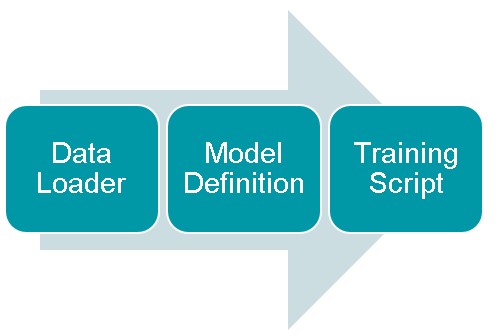

In [1]:
import os
import math

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            # Input
            layers.Input(input_shape),

            # 1st Conv block
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # 2nd Conv block
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
        
            # Classfier
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ]
    )

    return model

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     1

In [3]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name']. \
                          isin(invalid_filenames)]
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255.
            
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [4]:
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True)

In [ ]:
history = model.fit(
    train_generator,
    validation_generator=valid_generator,
    epochs=10,
    callbacks=[
        early_stopping,
        reduce_on_plateau,
        model_checkpoint
    ]
    verbose=1
)

# Callback functions

```
callbacks =  tf.keras.callbacks.CallbackList([...])
callbacks.append(...)

callbacks.on_train_begin(...)
for epoch in range(EPOCHS):
  callbacks.on_epoch_begin(epoch)
  for i, data in dataset.enumerate():
    callbacks.on_train_batch_begin(i)
    batch_logs = model.train_step(data)
    callbacks.on_train_batch_end(i, batch_logs)
  epoch_logs = ...
  callbacks.on_epoch_end(epoch, epoch_logs)
final_logs=...
callbacks.on_train_end(final_logs)
```

*   ```on_train_begin```
*   ```on_epoch_begin```
*   ```on_train_batch_begin```
*   ```on_train_batch_end```
*   ```on_epoch_end```
*   ```on_train_end```


*   ```keras.Model.fit()```
*   ```keras.Model.evaluate()```
*   ```keras.Model.predict()```

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1,
    mode='min', restore_best_weights=False
)

In [6]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1,
    mode='min', min_lr=0.001
)

In [7]:
filepath = '{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min'
)

In [8]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[
        early_stopping,
        reduce_on_plateau,
        model_checkpoint
    ],
    verbose=1
)

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 1.0686 - accuracy: 0.6473
Epoch 00001: val_loss improved from inf to 0.65360, saving model to 01-0.65.hdf5
46/46 [==============================] - 59s 1s/step - loss: 1.0686 - accuracy: 0.6473 - val_loss: 0.6536 - val_accuracy: 0.6780
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.6832
Epoch 00002: val_loss improved from 0.65360 to 0.64777, saving model to 02-0.65.hdf5
46/46 [==============================] - 56s 1s/step - loss: 0.6110 - accuracy: 0.6832 - val_loss: 0.6478 - val_accuracy: 0.6814
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.6760
Epoch 00003: val_loss did not improve from 0.64777
46/46 [==============================] - 56s 1s/step - loss: 0.6061 - accuracy: 0.6760 - val_loss: 0.6572 - val_accuracy: 0.6794
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.6914
Epoch 00004: val_los

In [12]:
history.history

{'loss': [1.0686217546463013,
  0.6109798550605774,
  0.606144905090332,
  0.5954369306564331,
  0.6124913692474365],
 'accuracy': [0.6472591161727905,
  0.6831800937652588,
  0.6760299801826477,
  0.6913517117500305,
  0.6835206151008606],
 'val_loss': [0.6535970568656921,
  0.6477676630020142,
  0.6572163701057434,
  0.6730905771255493,
  0.6695802211761475],
 'val_accuracy': [0.6780122518539429,
  0.6814159154891968,
  0.6793737411499023,
  0.6725663542747498,
  0.6766507625579834],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

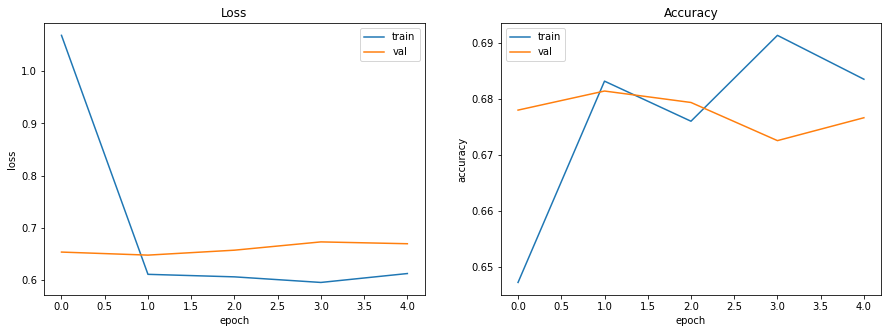

In [13]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()